**Códigos de ejemplo de las métricas y gráficos de error**

Se describen gráficos y ejemplos esenciales para mostrar la validación de los métodos numéricos de redes neuronales que resuelven ecuaciones diferenciales.

Se muestran tres casos con ejemplos, a saber:



*   Error absoluto
*   Error absoluto medio
*   Error cuadrático medio

Se hacen ejemplos para cada caso con soluciones con errores random, para ver como es cualitativamente, en los ejemplos y casos de estudio desarrollados en la icr, se muestran los gráficos de validación y códigos específicos.



**Error absoluto**


Error abosluto pra una EDO

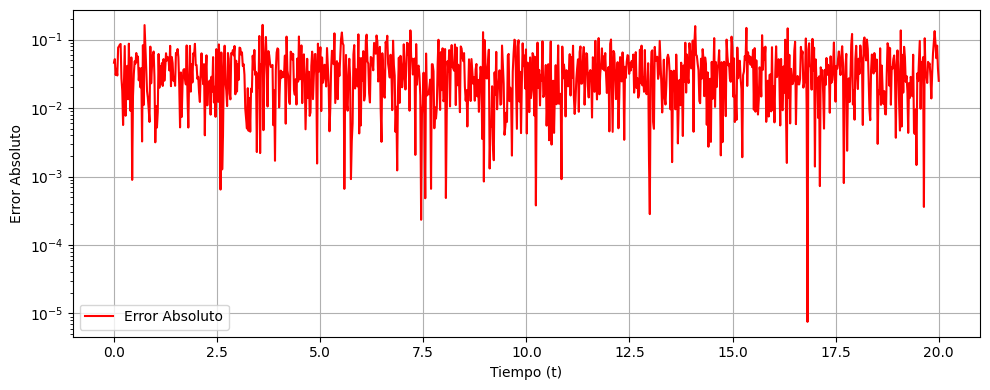

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
t = np.linspace(0, 20, 1000)
u_exact = np.exp(-t)
u_pred = np.exp(-t) + 0.05*np.random.normal(size=1000)  # Simulación de error

# Cálculo del error absoluto
error_abs = np.abs(u_pred - u_exact)

# Gráfico
plt.figure(figsize=(10, 4))
plt.plot(t, error_abs, label="Error Absoluto", color="red")
plt.yscale("log")  # Escala logarítmica para resaltar pequeños errores
plt.xlabel("Tiempo (t)")
plt.ylabel("Error Absoluto")
#plt.title("Error Absoluto en la Solución de una EDO")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("error_absoluto_edo.png", dpi=300, bbox_inches="tight")
plt.show()

Error absoluto para EDP

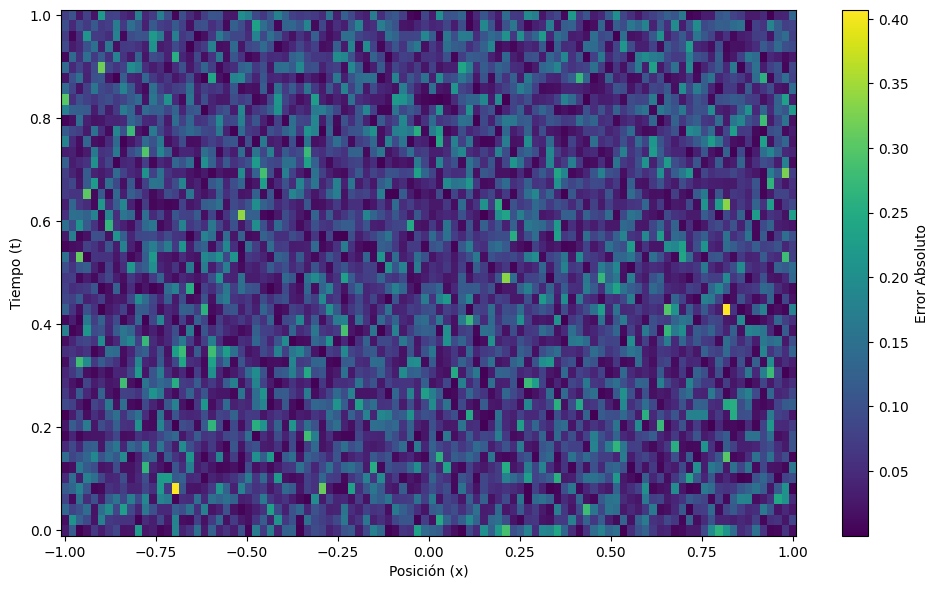

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo (simulación de una EDP)
x = np.linspace(-1, 1, 100)
t = np.linspace(0, 1, 50)
X, T = np.meshgrid(x, t)
u_exact = np.sin(np.pi * X) * np.exp(-T)
u_pred = u_exact + 0.1*np.random.normal(size=(50, 100))  # Simulación de error

# Cálculo del error absoluto
error_abs = np.abs(u_pred - u_exact)

# Gráfico de heatmap
plt.figure(figsize=(10, 6))
plt.pcolormesh(X, T, error_abs, cmap="viridis", shading="auto")
plt.colorbar(label="Error Absoluto")
plt.xlabel("Posición (x)")
plt.ylabel("Tiempo (t)")
#plt.title("Mapa de Error Absoluto para la Ecuación de Burgers")
plt.tight_layout()
plt.savefig("mapa_error_abs_burgers.png", dpi=300, bbox_inches="tight")
plt.show()

Error absoluto en PINNS

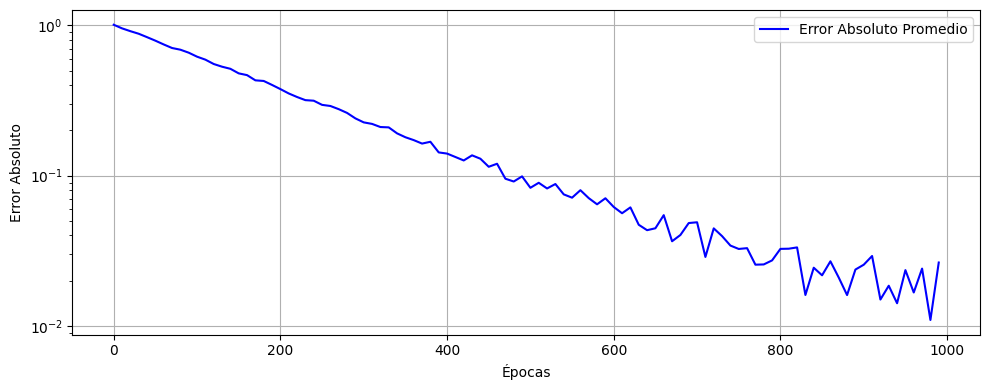

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos simulados de entrenamiento
epochs = np.arange(0, 1000, 10)
error_abs_epochs = np.exp(-epochs/200) + 0.02*np.random.rand(len(epochs))  # Error decreciente

# Gráfico de error vs. épocas
plt.figure(figsize=(10, 4))
plt.plot(epochs, error_abs_epochs, label="Error Absoluto Promedio", color="blue")
plt.yscale("log")
plt.xlabel("Épocas")
plt.ylabel("Error Absoluto")
#plt.title("Convergencia del Error Absoluto en un PINN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("error_absoluto_promedio.png", dpi=300, bbox_inches="tight")
plt.show()

Error MAE y MSE para ecuación diferencial de decaimiento.

Entrenamiento: 100%|██████████| 5000/5000 [00:11<00:00, 430.83it/s]


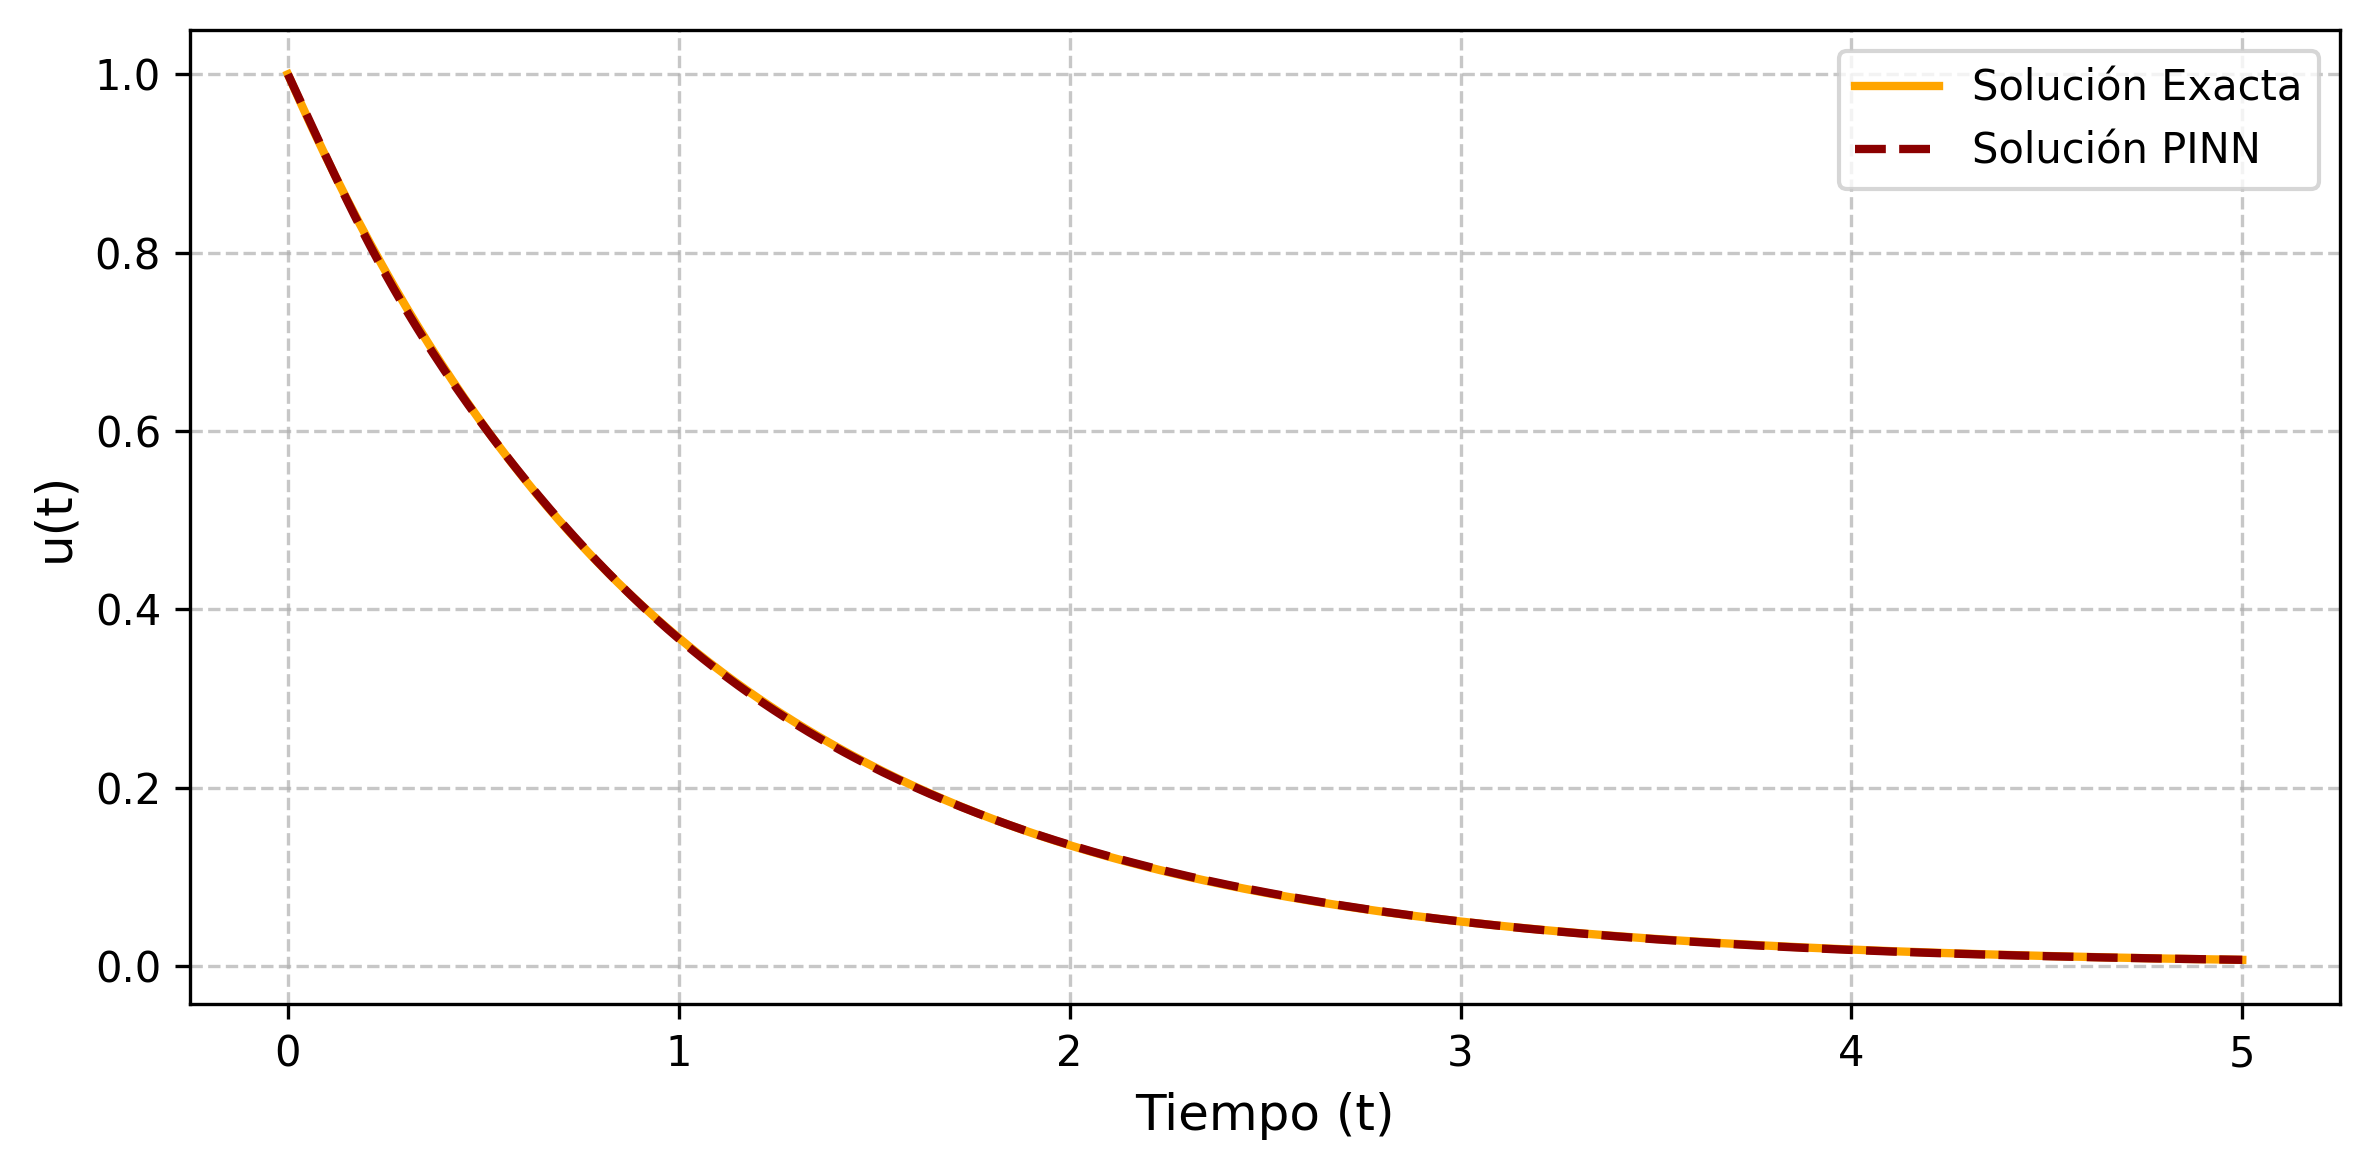

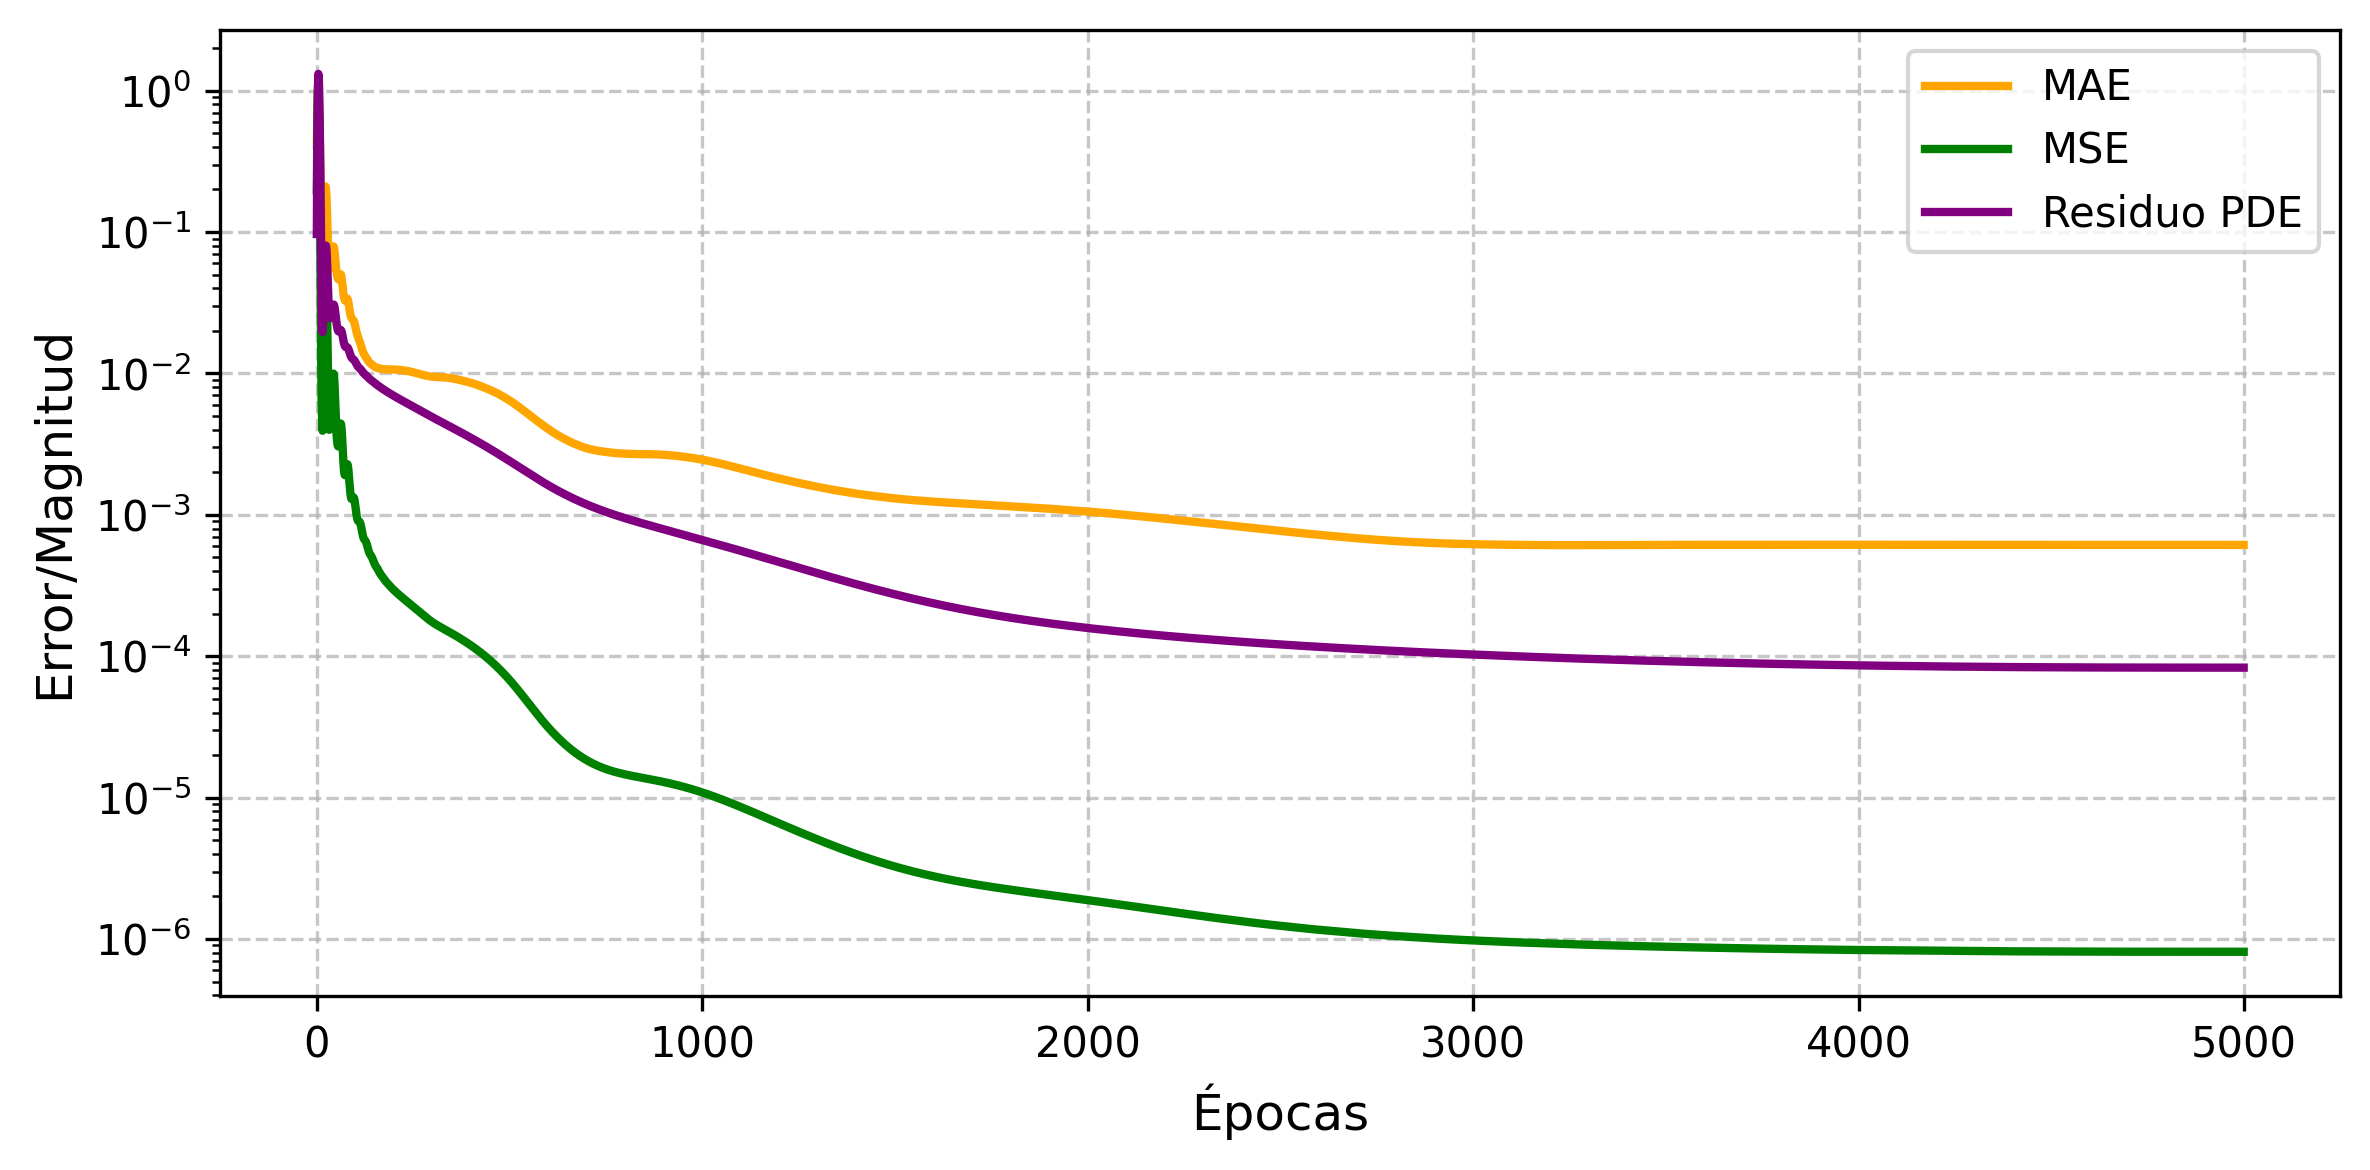

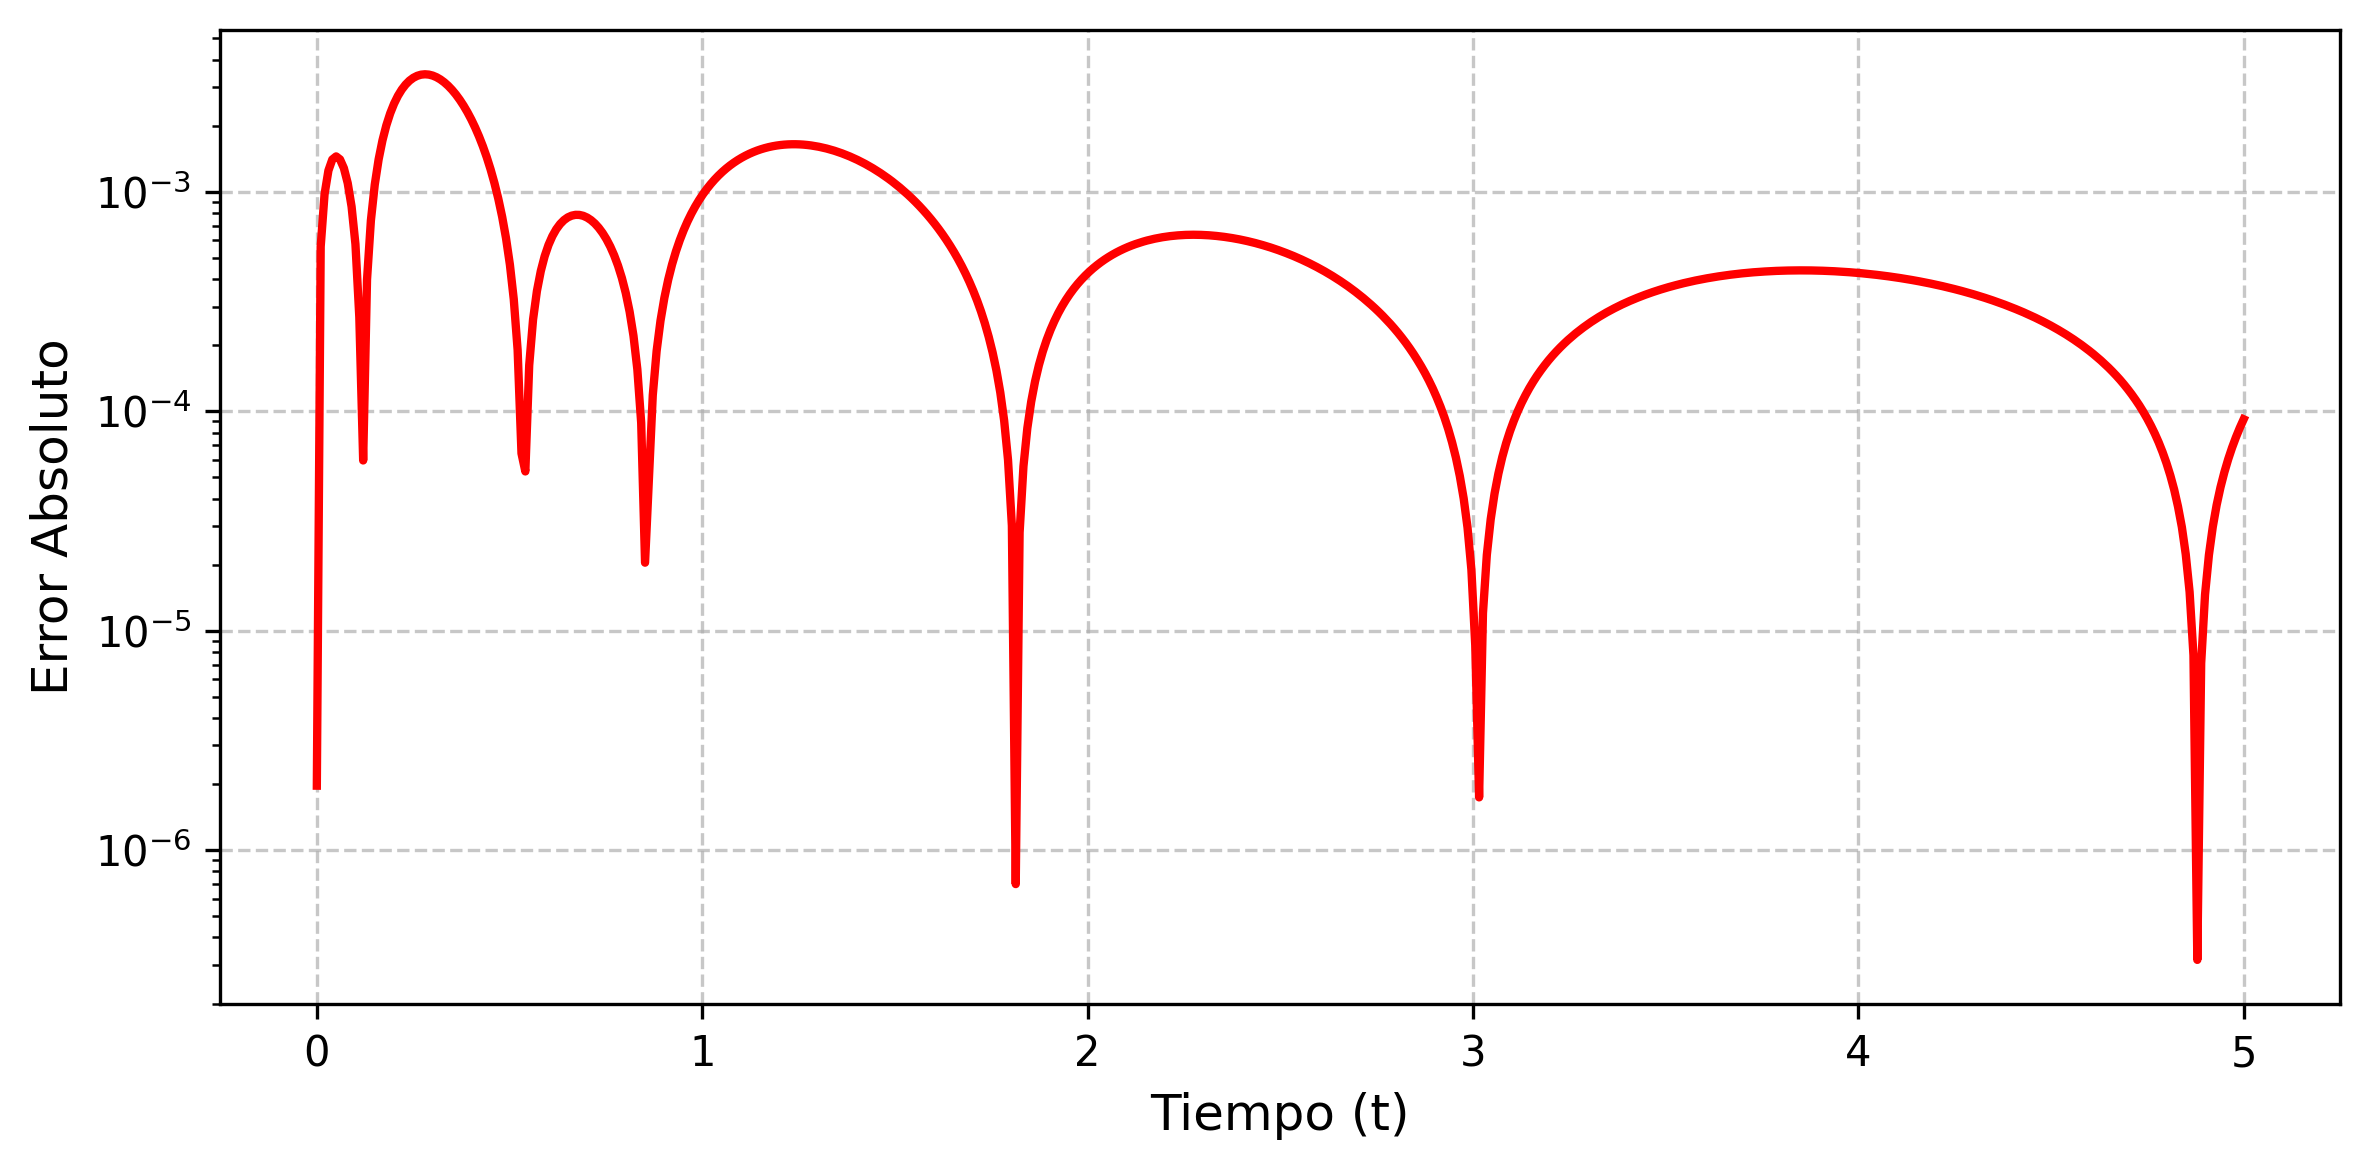

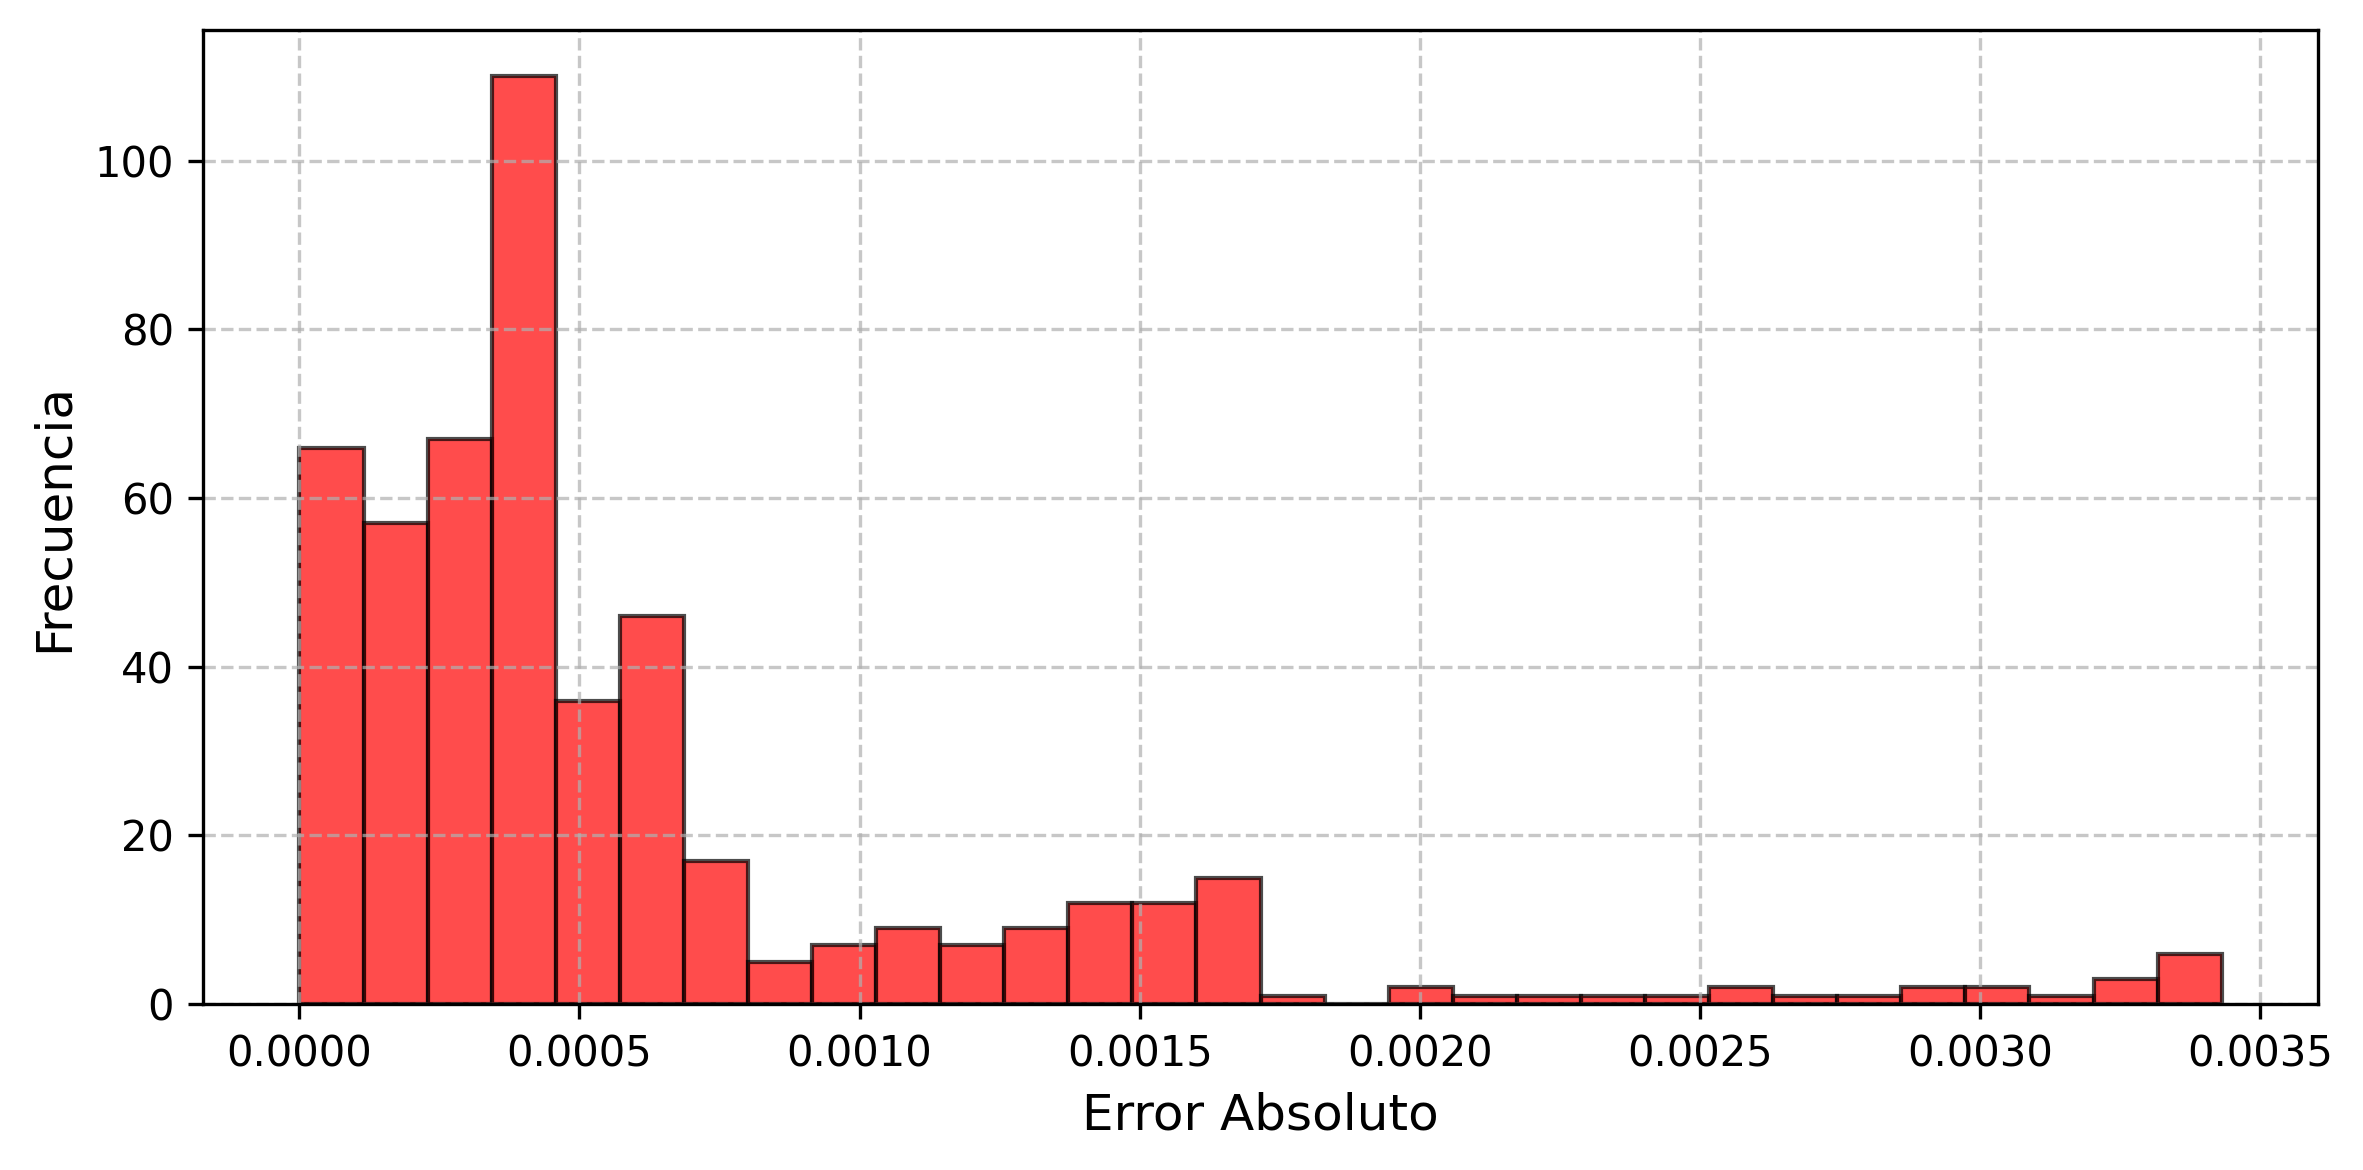

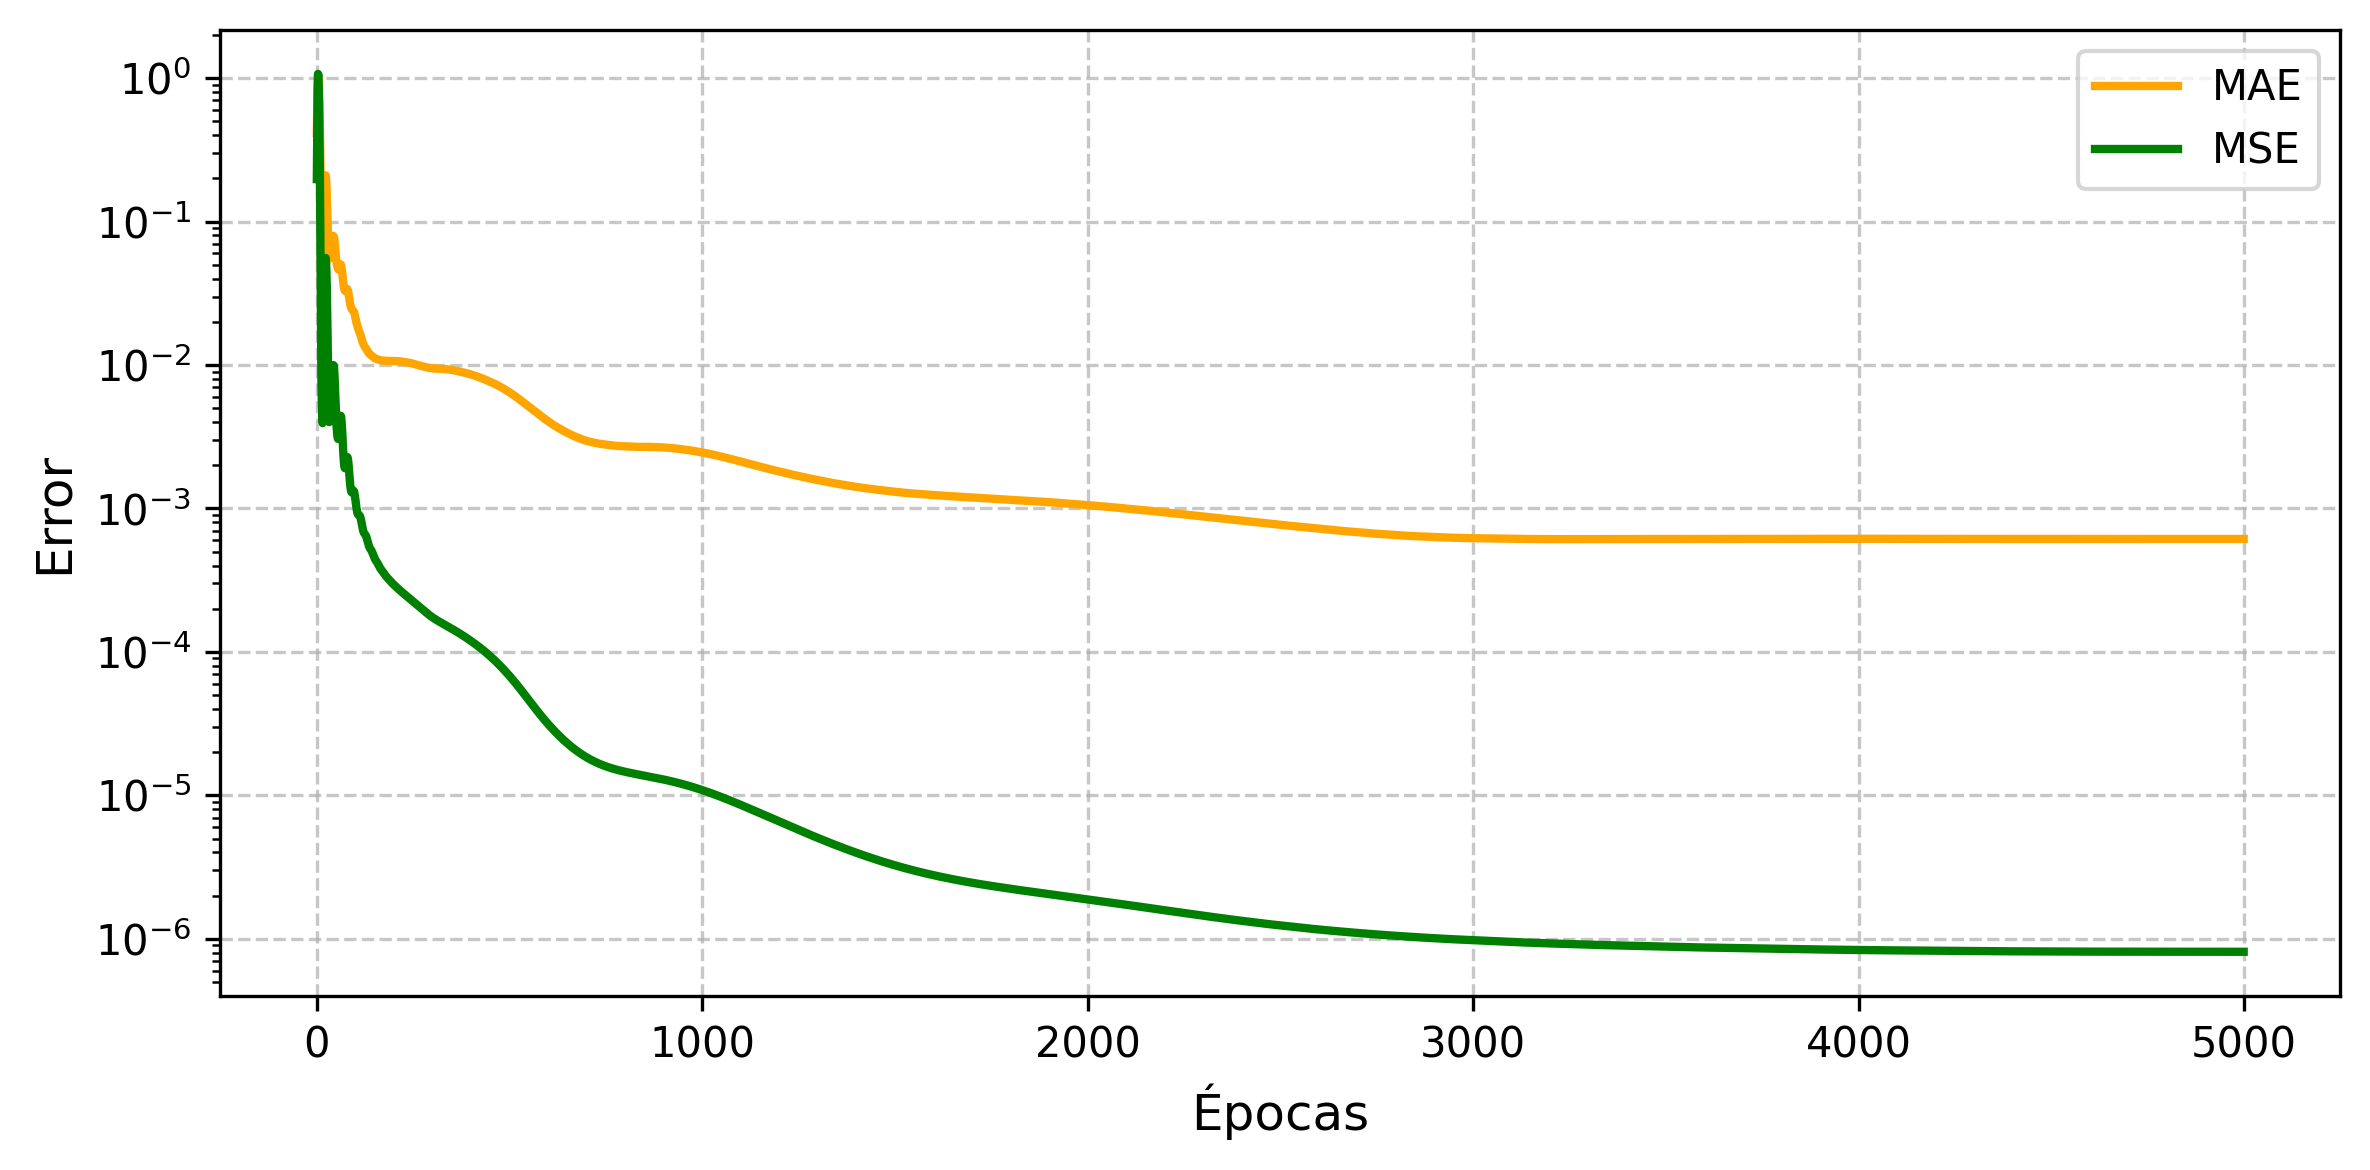

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

# ================================
# Parámetros y datos
# ================================
lambda_val = 1.0
t_max = 5.0
n_collocation = 100  # Puntos de colocación

# Datos de entrenamiento (puntos de colocación)
t_collocation = torch.linspace(0, t_max, n_collocation).reshape(-1, 1)
t_collocation.requires_grad_(True)  # Para calcular derivadas

# Solución exacta (para validación)
u_exact = torch.exp(-lambda_val * t_collocation).detach()

# ================================
# Modelo: Red Neuronal
# ================================
class PhysicsInformedNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, t):
        return self.fc(t)

model = PhysicsInformedNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5000)
criterion = nn.MSELoss()

# ================================
# Entrenamiento
# ================================
epochs = 5000
mae_history = []
mse_history = []
residual_history = []
abs_error_history = []  # Para almacenar el error absoluto promedio

for epoch in tqdm(range(epochs), desc="Entrenamiento"):
    # Forward pass
    u_pred = model(t_collocation)

    # Calcular residuo de la EDO: du/dt + lambda*u = 0
    du_dt = torch.autograd.grad(
        u_pred, t_collocation,
        grad_outputs=torch.ones_like(u_pred),
        create_graph=True
    )[0]
    residual = du_dt + lambda_val * u_pred

    # Pérdida total (residuo + condición inicial)
    loss_pde = criterion(residual, torch.zeros_like(residual))
    loss_ic = criterion(u_pred[0], torch.tensor([1.0]))  # u(0) = 1
    loss = loss_pde + 100 * loss_ic  # Peso mayor a la condición inicial

    # Backward pass y optimización
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Métricas (sin gradiente para evitar leaks)
    with torch.no_grad():
        u_pred_detached = model(t_collocation).detach()
        mae = torch.mean(torch.abs(u_pred_detached - u_exact)).item()
        mse = torch.mean((u_pred_detached - u_exact)**2).item()
        abs_error = torch.abs(u_pred_detached - u_exact).mean().item()  # Error absoluto promedio
        mae_history.append(mae)
        mse_history.append(mse)
        residual_history.append(loss_pde.item())
        abs_error_history.append(abs_error)

# ================================
# Evaluación y gráficas
# ================================
# Datos para evaluación (mayor resolución)
t_fine = torch.linspace(0, t_max, 500).reshape(-1, 1)
u_exact_fine = torch.exp(-lambda_val * t_fine).detach()
u_pred_fine = model(t_fine).detach()
error_abs_fine = torch.abs(u_pred_fine - u_exact_fine).numpy()

# -------------------
# Gráfica 1: Solución Predicha vs Exacta
# -------------------
plt.figure(figsize=(8, 4), dpi=300)
plt.plot(t_fine, u_exact_fine, label="Solución Exacta", color="orange", lw=2)
plt.plot(t_fine, u_pred_fine, "--", label="Solución PINN", color="darkred", lw=2)
plt.xlabel("Tiempo (t)", fontsize=12)
plt.ylabel("u(t)", fontsize=12)
#plt.title("Comparación de Soluciones", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("solucion_edo.png", dpi=300, bbox_inches="tight")
plt.show()

# -------------------
# Gráfica 2: Convergencia de Errores
# -------------------
plt.figure(figsize=(8, 4), dpi=300)
plt.plot(mae_history, label="MAE", color="orange", lw=2)
plt.plot(mse_history, label="MSE", color="green", lw=2)
plt.plot(residual_history, label="Residuo PDE", color="purple", lw=2)
plt.yscale("log")
plt.xlabel("Épocas", fontsize=12)
plt.ylabel("Error/Magnitud", fontsize=12)
#plt.title("Convergencia durante el Entrenamiento", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("convergencia_errores.png", dpi=300, bbox_inches="tight")
plt.show()

# -------------------
# Gráfica 3: Error Absoluto vs Tiempo
# -------------------
plt.figure(figsize=(8, 4), dpi=300)
plt.plot(t_fine, error_abs_fine, color="red", lw=2)
plt.xlabel("Tiempo (t)", fontsize=12)
plt.ylabel("Error Absoluto", fontsize=12)
#plt.title("Distribución del Error Absoluto", fontsize=14)
plt.yscale("log")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("error_absoluto.png", dpi=300, bbox_inches="tight")
plt.show()

# -------------------
# Gráfica 4: Histograma del Error Absoluto
# -------------------
plt.figure(figsize=(8, 4), dpi=300)
plt.hist(error_abs_fine.flatten(), bins=30, color="red", edgecolor="black", alpha=0.7)
plt.xlabel("Error Absoluto", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
#plt.title("Histograma del Error Absoluto", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("histograma_error_absoluto.png", dpi=300, bbox_inches="tight")
plt.show()

# -------------------
# Gráfica 5: Comparación MAE vs MSE
# -------------------
plt.figure(figsize=(8, 4), dpi=300)
plt.plot(mae_history, label="MAE", color="orange", lw=2)
plt.plot(mse_history, label="MSE", color="green", lw=2)
plt.yscale("log")
plt.xlabel("Épocas", fontsize=12)
plt.ylabel("Error", fontsize=12)
#plt.title("Comparación MAE vs MSE", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("comparacion_mae_mse.png", dpi=300, bbox_inches="tight")
plt.show()

Época 10/5000, Loss: 0.173043, MAE: 0.147866, MSE: 0.025503
Época 100/5000, Loss: 0.008082, MAE: 0.071110, MSE: 0.007335
Época 200/5000, Loss: 0.000432, MAE: 0.091720, MSE: 0.012484
Época 300/5000, Loss: 0.000149, MAE: 0.086905, MSE: 0.012710
Época 400/5000, Loss: 0.000085, MAE: 0.075347, MSE: 0.010703
Época 500/5000, Loss: 0.000064, MAE: 0.074723, MSE: 0.010320
Época 600/5000, Loss: 0.000052, MAE: 0.075936, MSE: 0.010202
Época 700/5000, Loss: 0.000044, MAE: 0.076748, MSE: 0.010076
Época 800/5000, Loss: 0.000037, MAE: 0.076977, MSE: 0.009885
Época 900/5000, Loss: 0.000061, MAE: 0.076515, MSE: 0.009651
Época 1000/5000, Loss: 0.000032, MAE: 0.076169, MSE: 0.009339
Época 1100/5000, Loss: 0.000025, MAE: 0.077048, MSE: 0.009362
Época 1200/5000, Loss: 0.000024, MAE: 0.077039, MSE: 0.009242
Época 1300/5000, Loss: 0.000020, MAE: 0.077084, MSE: 0.009145
Época 1400/5000, Loss: 0.000038, MAE: 0.077144, MSE: 0.009113
Época 1500/5000, Loss: 0.000018, MAE: 0.077336, MSE: 0.009037
Época 1600/5000, Lo

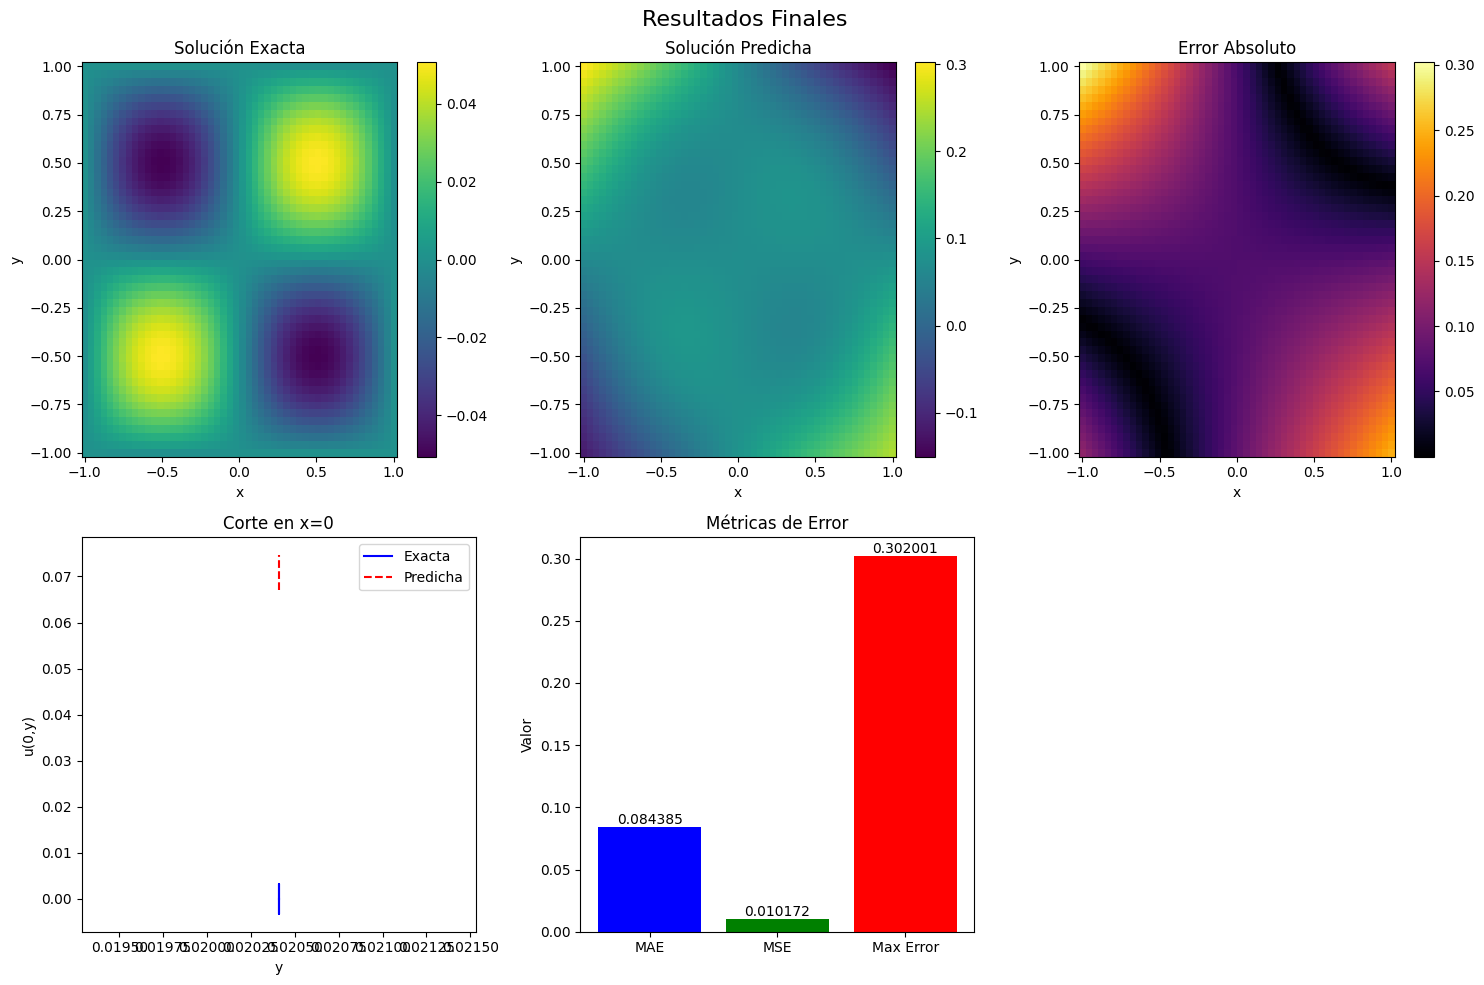

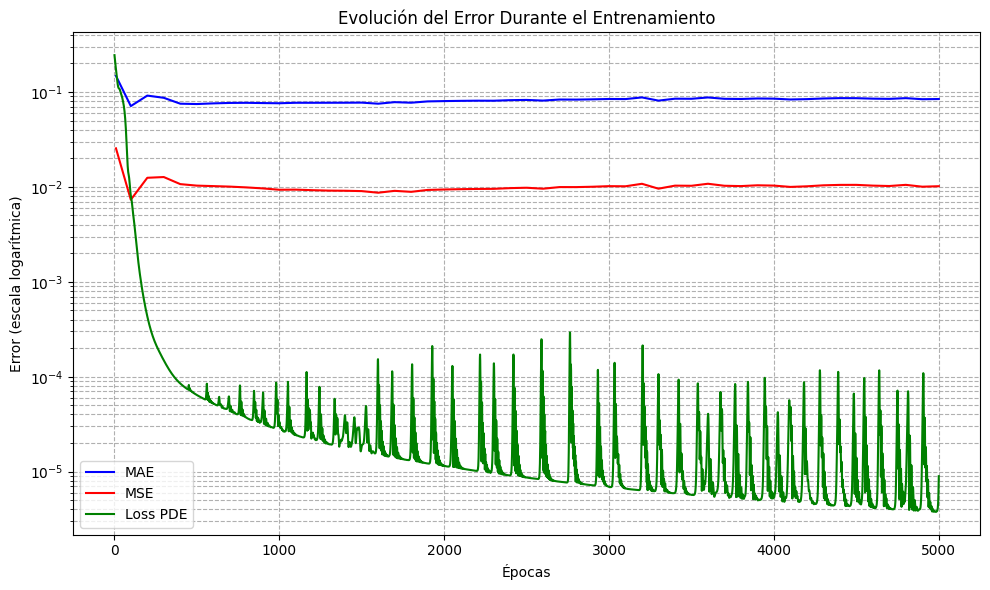


Tabla comparativa de errores:
Métrica         Valor      Descripción                                       
--------------- ---------- --------------------------------------------------
MAE             0.084385   Error absoluto medio - promedio de diferencias absolutas
MSE             0.010172   Error cuadrático medio - sensible a errores grandes
Max Error       0.302001   Error máximo - peor caso en todo el dominio       


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import grad
import matplotlib.pyplot as plt
import numpy as np

# Dominio
x = torch.linspace(-1, 1, 50)
y = torch.linspace(-1, 1, 50)
X, Y = torch.meshgrid(x, y, indexing="ij")
X_flat = X.flatten().unsqueeze(1)
Y_flat = Y.flatten().unsqueeze(1)

# Solución exacta
u_exact = torch.sin(torch.pi * X) * torch.sin(torch.pi * Y) / (2 * torch.pi**2)

# Red neuronal
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, y):
        return self.fc(torch.cat([x, y], dim=1))

model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Función de pérdida (residuo de la EDP)
def loss_pde(model, X, Y):
    x = X.requires_grad_()
    y = Y.requires_grad_()
    u = model(x, y)
    u_x = grad(u.sum(), x, create_graph=True)[0]
    u_xx = grad(u_x.sum(), x, create_graph=True)[0]
    u_y = grad(u.sum(), y, create_graph=True)[0]
    u_yy = grad(u_y.sum(), y, create_graph=True)[0]
    residual = u_xx + u_yy + torch.sin(torch.pi * x) * torch.sin(torch.pi * y)
    return criterion(residual, torch.zeros_like(residual))

# Función para calcular errores
def calculate_errors(u_pred, u_exact):
    u_pred_np = u_pred.detach().numpy() if isinstance(u_pred, torch.Tensor) else u_pred
    u_exact_np = u_exact.detach().numpy() if isinstance(u_exact, torch.Tensor) else u_exact

    mae = np.mean(np.abs(u_pred_np - u_exact_np))
    mse = np.mean((u_pred_np - u_exact_np)**2)
    max_error = np.max(np.abs(u_pred_np - u_exact_np))

    return mae, mse, max_error

# Función para visualizar los resultados
def visualize_results(X, Y, u_pred, u_exact, mae, mse, epoch=None):
    fig = plt.figure(figsize=(15, 10))

    # Solución exacta
    ax1 = fig.add_subplot(2, 3, 1)
    pcm1 = ax1.pcolormesh(X.numpy(), Y.numpy(), u_exact.numpy(), cmap="viridis")
    plt.colorbar(pcm1, ax=ax1)
    ax1.set_title("Solución Exacta")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    # Solución predicha
    ax2 = fig.add_subplot(2, 3, 2)
    pcm2 = ax2.pcolormesh(X.numpy(), Y.numpy(), u_pred.numpy(), cmap="viridis")
    plt.colorbar(pcm2, ax=ax2)
    ax2.set_title("Solución Predicha")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")

    # Error absoluto
    ax3 = fig.add_subplot(2, 3, 3)
    error_map = np.abs(u_pred.numpy() - u_exact.numpy())
    pcm3 = ax3.pcolormesh(X.numpy(), Y.numpy(), error_map, cmap="inferno")
    plt.colorbar(pcm3, ax=ax3)
    ax3.set_title("Error Absoluto")
    ax3.set_xlabel("x")
    ax3.set_ylabel("y")

    # Corte en x=0
    ax4 = fig.add_subplot(2, 3, 4)
    mid_idx = X.shape[0] // 2
    ax4.plot(Y[:, mid_idx].numpy(), u_exact[:, mid_idx].numpy(), 'b-', label='Exacta')
    ax4.plot(Y[:, mid_idx].numpy(), u_pred[:, mid_idx].numpy(), 'r--', label='Predicha')
    ax4.set_title("Corte en x=0")
    ax4.set_xlabel("y")
    ax4.set_ylabel("u(0,y)")
    ax4.legend()

    # Barras de error
    ax5 = fig.add_subplot(2, 3, 5)
    errors = [mae, mse, np.max(error_map)]
    labels = ['MAE', 'MSE', 'Max Error']
    ax5.bar(labels, errors, color=['blue', 'green', 'red'])
    for i, v in enumerate(errors):
        ax5.text(i, v, f'{v:.6f}', ha='center', va='bottom')
    ax5.set_title("Métricas de Error")
    ax5.set_ylabel("Valor")

    # Título general
    if epoch is not None:
        fig.suptitle(f"Resultados - Época {epoch}", fontsize=16)
    else:
        fig.suptitle("Resultados Finales", fontsize=16)

    plt.tight_layout()
    return fig

# Entrenamiento con seguimiento de errores
epochs = 5000
checkpoint_epochs = [10, 100, 500, 1000, 5000]  # Épocas para guardar visualizaciones
loss_history = []
mae_history = []
mse_history = []
epoch_records = []  # Lista para registrar las épocas donde calculamos métricas

for epoch in range(epochs):
    # Entrenamiento
    loss = loss_pde(model, X_flat, Y_flat)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Guardar el historial de pérdida
    loss_history.append(loss.item())

    # Evaluar el modelo cada 100 épocas o en puntos de control
    if (epoch + 1) % 100 == 0 or (epoch + 1) in checkpoint_epochs:
        with torch.no_grad():
            u_pred = model(X_flat, Y_flat).reshape(X.shape)
            mae, mse, _ = calculate_errors(u_pred, u_exact)
            mae_history.append(mae)
            mse_history.append(mse)
            epoch_records.append(epoch + 1)  # Guardamos la época actual

        print(f"Época {epoch+1}/{epochs}, Loss: {loss.item():.6f}, MAE: {mae:.6f}, MSE: {mse:.6f}")

        # Crear visualizaciones en épocas específicas
        if (epoch + 1) in checkpoint_epochs:
            fig = visualize_results(X, Y, u_pred, u_exact, mae, mse, epoch + 1)
            plt.savefig(f"pinn_results_epoch_{epoch+1}.png")
            plt.close(fig)

# Evaluación final
with torch.no_grad():
    u_pred = model(X_flat, Y_flat).reshape(X.shape)
    mae, mse, max_error = calculate_errors(u_pred, u_exact)

print(f"Resultados finales - MAE: {mae:.6f}, MSE: {mse:.6f}, Max Error: {max_error:.6f}")

# Visualización final
visualize_results(X, Y, u_pred, u_exact, mae, mse)
plt.savefig("pinn_results_final.png")
plt.show()

# Gráfico de evolución del error
plt.figure(figsize=(10, 6))

# Usamos epoch_records para asegurarnos de que las dimensiones coincidan
plt.semilogy(epoch_records, mae_history, 'b-', label='MAE')
plt.semilogy(epoch_records, mse_history, 'r-', label='MSE')
plt.semilogy(range(1, epochs+1), loss_history, 'g-', label='Loss PDE')

plt.xlabel('Épocas')
plt.ylabel('Error (escala logarítmica)')
plt.title('Evolución del Error Durante el Entrenamiento')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig("pinn_error_evolution.png")
plt.show()

# Tabla comparativa de errores
print("\nTabla comparativa de errores:")
print(f"{'Métrica':<15} {'Valor':<10} {'Descripción':<50}")
print(f"{'-'*15} {'-'*10} {'-'*50}")
print(f"{'MAE':<15} {mae:<10.6f} {'Error absoluto medio - promedio de diferencias absolutas':<50}")
print(f"{'MSE':<15} {mse:<10.6f} {'Error cuadrático medio - sensible a errores grandes':<50}")
print(f"{'Max Error':<15} {max_error:<10.6f} {'Error máximo - peor caso en todo el dominio':<50}")